# Import

In [1]:
TARGET = 'readmission_30d'

In [2]:
import numpy as np 
import pandas as pd 

import os
import yaml

import lightgbm as lgb

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score

from tqdm.notebook import tqdm

# Load

In [3]:
df_raw = pd.read_csv("dataset/processed_data.csv", dtype={'date_procedure_9': 'str', 'date_procedure_10': 'str'})
df_raw.head()

,Unnamed: 0,sex,dob,age,race,education_level,zipcode,patient_city,patient_state,underlying_heart_disease,...,n_procedure_180d,n_procedure_1year,classe_meds_cardio_qtde,meds_cardiovasc_qtde,meds_antimicrobianos,nyha_basal_group,cied_final_group_1,procedure_type_new,hospital_stay,split
0,1,1,1966-01-23,44.6,1.0,2.0,3343010,SAO PAULO,35.0,1.0,...,0,0,3.0,6.0,3.0,1.0,1,2,1,train
1,2,1,1961-09-29,51.1,1.0,4.0,71505275,BRASILIA,53.0,1.0,...,0,0,NaN,0.0,4.0,1.0,1,1,2,train
2,3,0,1945-08-09,60.1,1.0,4.0,71015068,BRASILIA,53.0,1.0,...,0,0,NaN,0.0,0.0,1.0,1,2,1,train
3,4,1,1948-01-25,61.0,1.0,4.0,70753010,BRASILIA,53.0,2.0,...,0,0,NaN,0.0,8.0,1.0,1,1,2,train
4,5,1,1934-10-06,69.1,1.0,999.0,70386110,BRASILIA,53.0,NaN,...,0,0,NaN,NaN,NaN,NaN,1,1,8,train


In [4]:
with open("auxiliar/significant_columns/categorical_{}.yaml".format(TARGET), "r") as stream:
    try:
        initial_cat_features = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)
        
with open("auxiliar/significant_columns/numerical_{}.yaml".format(TARGET), "r") as stream:
    try:
        initial_num_features = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)
        
initial_features = initial_cat_features + initial_num_features

In [5]:
exception_columns = ['death_intraop', 'death_intraop_1', 'disch_outcomes_t0']

correlated_columns = ['year_procedure_1', # com year_adm_t0
                       'age_surgery_1', # com age
                       'admission_t0', # com admission_pre_t0_count
                       'atb', # com meds_antimicrobianos
                       'classe_meds_cardio_qtde', # com classe_meds_qtde
                       'suporte_hemod', # com proced_invasivos_qtde,
                       'radiografia', # com exames_imagem_qtde
                       'ecg' # com metodos_graficos_qtde
                     ]

initial_features = list(set(initial_features) - set(exception_columns + correlated_columns))

# Split

In [6]:
X_df = df_raw[initial_features]
y_df = df_raw[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df,
                                                    test_size = 0.3,
                                                    random_state = 0,
                                                    stratify = y_df)

In [7]:
print("Training features shape: ", X_train.shape)
print("Testing features shape: ", X_test.shape)

Training features shape:  (11036, 76)
Testing features shape:  (4730, 76)


# Baseline

In [8]:
N_FOLDS = 5
MAX_EVALS = 5

In [9]:
train_set = lgb.Dataset(data=X_train, label = y_train, free_raw_data = False)
test_set = lgb.Dataset(data = X_test, label = y_test, free_raw_data = False)

In [10]:
# Get default hyperparameters
model = lgb.LGBMClassifier()
default_params = model.get_params()

# Remove the number of estimators because we set this to 10000 in the cv call
del default_params['n_estimators']
del default_params['importance_type']
del default_params['silent']

# Cross validation with early stopping
cv_results = lgb.cv(default_params, train_set, num_boost_round = 10000,
                    callbacks=[lgb.early_stopping(stopping_rounds = 200)], 
                    metrics = 'auc', nfold = N_FOLDS, seed = 314)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002203 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3178
[LightGBM] [Info] Number of data points in the train set: 8828, number of used features: 73
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001371 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3178
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 73
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3178
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 73

In [11]:
print('The maximum validation ROC AUC was: {:.5f} with a standard deviation of {:.5f}.'.format(cv_results['auc-mean'][-1], cv_results['auc-stdv'][-1]))
print('The optimal number of boosting rounds (estimators) was {}.'.format(len(cv_results['auc-mean'])))

The maximum validation ROC AUC was: 0.67453 with a standard deviation of 0.04569.
The optimal number of boosting rounds (estimators) was 58.


In [12]:
# Optimal number of esimators found in cv
model.n_estimators = len(cv_results['auc-mean'])
# model.n_estimators = 80

# Train and make predicions with model
model.fit(X_train, y_train)
preds = model.predict_proba(X_test)[:, 1]
baseline_auc = roc_auc_score(y_test, preds)

print('The baseline model scores {:.5f} ROC AUC on the test set.'.format(baseline_auc))

The baseline model scores 0.63461 ROC AUC on the test set.


In [13]:
feature_importances = np.zeros(X_test.shape[1])
feature_importances += model.feature_importances_
print(feature_importances)

[53. 29. 80.  1.  0.  0. 53.  0.  9.  0. 62.  6.  2.  6. 75. 18. 36. 33.
  9. 17.  6. 79.  5.  3.  9. 55. 17.  8.  0.  0.  4.  8. 88.  0.  5. 17.
 10.  0.  0.  5.  6.  0. 61. 11. 19. 16.  1. 63. 20. 17.  3. 26. 57.  8.
 51. 17.  6.  1.  2. 14.  0. 50. 45. 38. 19. 21.  8. 60. 46. 10. 44.  2.
  1. 68. 60. 61.]


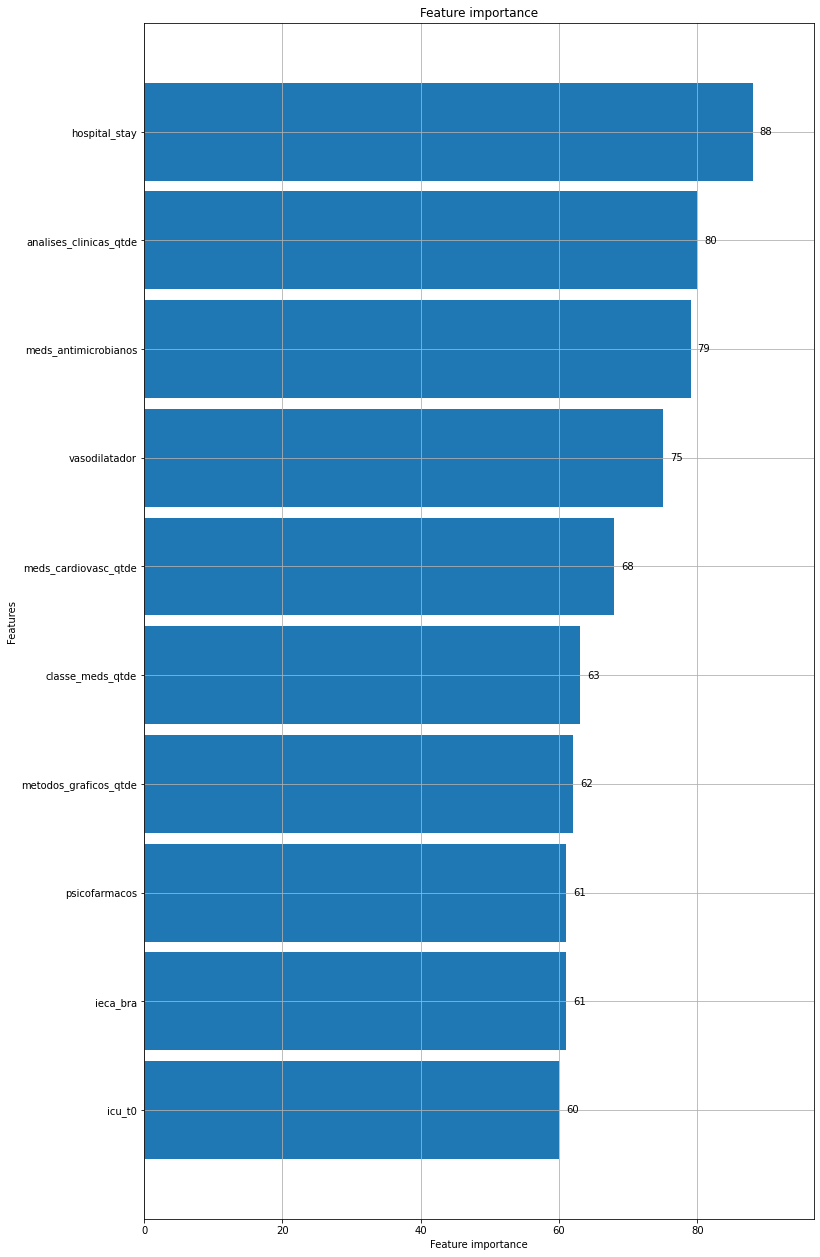

In [14]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 22)
lgb.plot_importance(model, max_num_features = 10, height=.9)
plt.show()

In [15]:
It = 20
df_prot_train = X_train.iloc[:, feature_importances>=It]
ds_prot_train = lgb.Dataset(data = df_prot_train, label = y_train, free_raw_data = False)

df_prot_test = X_test.iloc[:, feature_importances>=It]
ds_prot_test = lgb.Dataset(data = df_prot_test, label = y_test, free_raw_data = False)
sum(feature_importances>=It)

27

In [16]:
# Get default hyperparameters
clf = lgb.LGBMClassifier()
default_params = clf.get_params()

# Remove the number of estimators because we set this to 10000 in the cv call
del default_params['n_estimators']
del default_params['importance_type']
del default_params['silent']

# Cross validation with early stopping
cv_results = lgb.cv(default_params, ds_prot_train, num_boost_round = 10000,
                    callbacks=[lgb.early_stopping(stopping_rounds = 200)], 
                    metrics = 'auc', nfold = N_FOLDS, seed = 314)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2464
[LightGBM] [Info] Number of data points in the train set: 8828, number of used features: 27
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001174 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2464
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 27
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001661 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2464
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 27
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, th

In [17]:
# Optimal number of esimators found in cv
clf.n_estimators = len(cv_results['auc-mean'])
# model.n_estimators = 80

# Train and make predicions with model
print
clf.fit(df_prot_train, y_train)
preds = clf.predict_proba(df_prot_test)[:, 1]
baseline_auc = roc_auc_score(y_test, preds)

print('The baseline model scores {:.5f} ROC AUC on the test set.'.format(baseline_auc))

The baseline model scores 0.65907 ROC AUC on the test set.


# Hyperparameter Tuning

In [18]:
def objective(train_set, hyperparameters, iteration):
    """Objective function for grid and random search. Returns
       the cross validation score from a set of hyperparameters."""
    
    # Number of estimators will be found using early stopping
    if 'n_estimators' in hyperparameters.keys():
        del hyperparameters['n_estimators']
    
     # Perform n_folds cross validation
    cv_results = lgb.cv(hyperparameters, train_set, num_boost_round = 10000, nfold = N_FOLDS, 
                        callbacks=[lgb.early_stopping(stopping_rounds = 200)], metrics = 'auc', seed = 42)
    
    # results to retun
    score = cv_results['auc-mean'][-1]
    estimators = len(cv_results['auc-mean'])
    hyperparameters['n_estimators'] = estimators 
    
    return [score, hyperparameters, iteration]

In [19]:
import itertools
import random

def random_search(train_set, param_grid, max_evals = MAX_EVALS):
    """Random search for hyperparameter optimization"""
    
    # Dataframe for results
    results = pd.DataFrame(columns = ['score', 'hyperparameters', 'iteration'],
                                  index = list(range(MAX_EVALS)))
    
    # Keep searching until reach max evaluations
    for i in tqdm(range(MAX_EVALS)):
        
        # Choose random hyperparameters
        hyperparameters = {k: random.sample(v, 1)[0] for k, v in param_grid.items()}
        hyperparameters['subsample'] = 1.0 if hyperparameters['boosting_type'] == 'goss' else hyperparameters['subsample']

        # Evaluate randomly selected hyperparameters
        eval_results = objective(train_set, hyperparameters, i)
        
        results.loc[i, :] = eval_results
    
    # Sort with best score on top
    results.sort_values('score', ascending = False, inplace = True)
    results.reset_index(inplace = True)
    return results 

In [23]:
# Hyperparameter grid
param_grid = {
    'boosting_type': ['gbdt', 'goss', 'dart'],
    'num_leaves': list(range(5, 25)),
    'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.5), base = 10, num = 1000)),
    'subsample_for_bin': list(range(20000, 300000, 20000)),
    'min_child_samples': list(range(20, 500, 5)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.6, 1, 10)),
    'subsample': list(np.linspace(0.5, 1, 100)),
    'is_unbalance': [True, False]
}

In [ ]:
random_results = random_search(ds_prot_train, param_grid)

print('The best validation score was {:.5f}'.format(random_results.loc[0, 'score']))
print('\nThe best hyperparameters were:')

import pprint
pprint.pprint(random_results.loc[0, 'hyperparameters'])

  0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2464
[LightGBM] [Info] Number of data points in the train set: 8828, number of used features: 27
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2464
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 27
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2464
[LightGBM] [Info] Number of data points in the train set: 8829, number of used features: 27

C:\Users\p_mat\anaconda3\lib\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


In [59]:
# Get the best parameters
random_search_params = random_results.loc[0, 'hyperparameters']

# Create, train, test model
model = lgb.LGBMClassifier(**random_search_params, random_state = 42)
model.fit(X_train, y_train)

preds = model.predict_proba(X_test)[:, 1]

print('The best model from random search scores {:.5f} ROC AUC on the test set.'.format(roc_auc_score(y_test, preds)))

The best model from random search scores 0.80904 ROC AUC on the test set.


In [60]:
pd.options.display.max_colwidth = 100
random_results['hyperparameters'].values

array([{'boosting_type': 'goss', 'num_leaves': 8, 'learning_rate': 0.005715155645572393, 'subsample_for_bin': 200000, 'min_child_samples': 425, 'reg_alpha': 0.2857142857142857, 'reg_lambda': 0.9387755102040816, 'colsample_bytree': 0.6888888888888889, 'subsample': 1.0, 'is_unbalance': True, 'n_estimators': 2661},
       {'boosting_type': 'gbdt', 'num_leaves': 12, 'learning_rate': 0.3538505330590944, 'subsample_for_bin': 180000, 'min_child_samples': 380, 'reg_alpha': 0.4693877551020408, 'reg_lambda': 0.7755102040816326, 'colsample_bytree': 0.9555555555555555, 'subsample': 0.6717171717171717, 'is_unbalance': False, 'n_estimators': 13},
       {'boosting_type': 'gbdt', 'num_leaves': 10, 'learning_rate': 0.3791838957498595, 'subsample_for_bin': 260000, 'min_child_samples': 380, 'reg_alpha': 0.6122448979591836, 'reg_lambda': 0.4081632653061224, 'colsample_bytree': 0.7333333333333333, 'subsample': 0.6565656565656566, 'is_unbalance': True, 'n_estimators': 38},
       {'boosting_type': 'gbdt', 

In [61]:
def evaluate(results, name):
    """Evaluate model on test data using hyperparameters in results
       Return dataframe of hyperparameters"""
        
    # Sort with best values on top
    results = results.sort_values('score', ascending = False).reset_index(drop = True)
    
    # Print out cross validation high score
    print('The highest cross validation score from {} was {:.5f} found on iteration {}.'.format(name, results.loc[0, 'score'], results.loc[0, 'iteration']))
    
    # Use best hyperparameters to create a model
    hyperparameters = results.loc[0, 'hyperparameters']
    model = lgb.LGBMClassifier(**hyperparameters)
    
    # Train and make predictions
    model.fit(X_train, y_train)
    preds = model.predict_proba(X_test)[:, 1]
    
    print('ROC AUC from {} on test data = {:.5f}.'.format(name, roc_auc_score(y_test, preds)))
    
    # Create dataframe of hyperparameters
    hyp_df = pd.DataFrame(columns = list(results.loc[0, 'hyperparameters'].keys()))

    # Iterate through each set of hyperparameters that were evaluated
    for i, hyp in enumerate(results['hyperparameters']):
        hyp_df = hyp_df.append(pd.DataFrame(hyp, index = [0]), 
                               ignore_index = True)
        
    # Put the iteration and score in the hyperparameter dataframe
    hyp_df['iteration'] = results['iteration']
    hyp_df['score'] = results['score']
    
    return hyp_df

In [62]:
random_hyp = evaluate(random_results, name = 'random search')

The highest cross validation score from random search was 0.78964 found on iteration 3.
ROC AUC from random search on test data = 0.80982.


C:\Users\p_mat\AppData\Local\Temp\ipykernel_46100\2252053390.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hyp_df = hyp_df.append(pd.DataFrame(hyp, index = [0]),
C:\Users\p_mat\AppData\Local\Temp\ipykernel_46100\2252053390.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hyp_df = hyp_df.append(pd.DataFrame(hyp, index = [0]),
C:\Users\p_mat\AppData\Local\Temp\ipykernel_46100\2252053390.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hyp_df = hyp_df.append(pd.DataFrame(hyp, index = [0]),
C:\Users\p_mat\AppData\Local\Temp\ipykernel_46100\2252053390.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hyp_df = hyp_df.append(